# COMP2002 Main Assignment
Machine Learning and Evolutionary Computation

In [5]:
import pandas
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

## Part 1- Machine Learning

### 1.1 Data Preparation
The forest fire datasets are CSVs with the following fields:
<table><tr>
    <td>Day</td>
    <td>Month</td>
    <td>Year</td>
    <td>Temperature (degrees C)</td>
    <td>RH (Relative Humidity, %)</td>
    <td>WS (Wind speed, kmph)</td>
    <td>Rain (Total for day, mm)</td>
    <td>FFMC (Fine Fuel Moisture Code index)</td>
    <td>DMC (Duff Moisture Code index)</td>
    <td>DC (Drought Code index)</td>
    <td>ISI (Initial Spread Index)</td>
    <td>BUI (Buildup Index)</td>
    <td>FWI (Fire Weather Index)</td></tr></table>

In [2]:
# Read in forest fire datasets
ff_region1 = pandas.read_csv("datasets/AlgerianFF_Region1.csv")
ff_region2 = pandas.read_csv("datasets/AlgerianFF_Region2.csv")
ff_combined = pandas.concat([ff_region1, ff_region2])
# Normalise the data so that all features are in range 0-1, while also removing the year (every value is the same so it is not useful)
scaler = MinMaxScaler()  # Range 0-1 is default
ff_combined_inputs = scaler.fit_transform(ff_combined[["month", "Temperature", " RH", " Ws", "Rain ", "FFMC", "DMC", "DC", "ISI", "BUI"]])
# Randomly split into training and testing data (random_state given so that the same shuffle will be done on each run, making results reproducible)
ff_train_inputs, ff_test_inputs, ff_train_targets, ff_test_targets = train_test_split(ff_combined_inputs, ff_combined["FWI"].values, shuffle=True, random_state=1)
# First record will be used to demonstrate that the regressors can make predictions
demonstration_inputs = [ff_test_inputs[0]]
demonstration_target = [ff_test_targets[0]]

- The datasets for the two regions were combined and then randomly split into testing and training data (as opposed to using one region for training and the other for testing) in case there are any features that are not in the dataset that differentiate the two regions which could cause the models to overfit to the training region
    - `train_test_split` uses the default training and test sizes, meaning 75% of the data is used for training and 25% for testing
- The first record from the test data is placed in `demonstration_inputs` and `demonstration_target` for use in task 1.2 to show that the regressors can make predictions

### 1.2 Regression

In [3]:
# Random Forest Regressor
RF_regressor = RandomForestRegressor()
# Neural Network
NN_regressor = MLPRegressor(max_iter=6000, solver="lbfgs")
# Support Vector Machine
SVM_regressor = SVR(kernel="poly", coef0=10)

In [4]:
# Demonstrate that the regressors can make predictions
RF_regressor.fit(ff_train_inputs, ff_train_targets)
NN_regressor.fit(ff_train_inputs, ff_train_targets)
SVM_regressor.fit(ff_train_inputs, ff_train_targets)

print("Random Forest prediction: %.2f" % RF_regressor.predict(demonstration_inputs)[0])
print("Neural Network prediction: %.2f" % NN_regressor.predict(demonstration_inputs)[0])
print("SVM prediction: %.2f" % SVM_regressor.predict(demonstration_inputs)[0])
print("Correct FWI: %.2f" % demonstration_target[0])

Random Forest prediction: 7.63
Neural Network prediction: 8.14
SVM prediction: 7.82
Correct FWI: 8.00


#### Tuning

To improve understanding of the models, tuning was done manually rather than using `GridSearchCV` or `RandomizedSearchCV`
##### Data Preparation
- Removed day from input data to see if this improved generalisability
    - The difference was negligible so day was not put back to improve compute time
- Tried using PCA with between 2 and 9 principal components
    - Even with 9 components, cross validation performance was considerably worse for all three models, so PCA was removed

##### Random Forest
- Increased `n_estimators` to 500, but performance impact was negligible, so it was reverted back to the default (100) as it increased compute time considerably
- Experimented with the different presets for `max_features` as having it too high can cause overfitting (Jermain, 2019)
    - Both "sqrt" and "log2" resulted in higher maximums on the boxplot, and caused the plot to skew towards higher values. The model was therefore reverted back to "auto" (which sets `max_features` to however many features there are)
- Experimented with different values for `max_depth` as the default value is no maximum depth, and having the depth too high can allow overfitting (Jermain, 2019)
    - Started from `max_depth=1` and worked upwards
    - Cross validation performance was much poorer but quickly improved as `max_depth` was incremented.  At `max_depth=5` the difference in performance compared with no maximum depth was negligible
    - But increasing `max_depth` further gave no further performance improvement, suggesting that the unlimited maximum depth is not causing overfitting.  It was therefore reverted back to the default
- Changed `min_samples_split`
    - Setting it to 5 (as opposed to the default of 2) had no impact on performance, but setting it to 10 reduced performance slightly so it was reverted back to the default
- Changed `min_samples_leaf`
    - Began increasing it from the default of 1.  This had no impact until it reached 5, at which point performance started to get worse so it was reverted back to the default
- Changed `max_leaf_nodes`
    - Initially this made performance worse, but by `max_leaf_nodes=20` it was not noticably different from the default.  Further increasing provided no performance gain so the parameter was reverted back to the default

Tuning seems to have little effect on the Random Forest, which is in keeping with its reputation for having good performance "out of the box" (Boehmke and Greenwell, 2020).

##### Neural Network
- The Neural Network model initially performed far worse than the other two, and was displaying "Convergence Warnings"
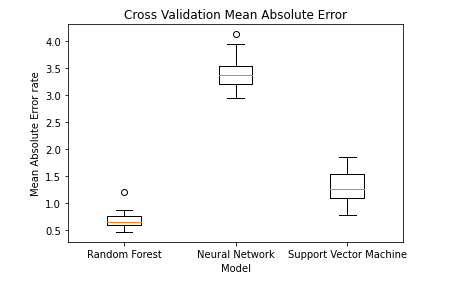
- This indicated that the model was reaching the maximum number of iterations before it was trained to a suitable level, meaning that the model could do better if it was allowed enough iterations
    - Starting from 500, the `max_iter` parameter was increased in large increments until the convergence warning stopped appearing.  When testing with `max_iter=5750` the model still showed the warning on one of the `RepeatedKFold` repeats so it was set to 6000 to give plenty of room for random variations in the number of iterations needed
    - The cross validation performance improved each time `max_iter` was incremented up until the convergence warnings stopped.  This suggests that not limiting the iterations is not causing overfitting.
        - Therefore `early_stopping` was not set to true
- Tried each of the activation functions offered by `MLPRegressor` but reverted back to the default ("relu")
    - "identity" gave worse cross validation results
    - "logistic" and "tanh" both gave convergence warnings.  It was decided that allowing any more iterations would take an unacceptable amount of compute time
- Tried each of the solvers offered
    - "sgd" was the least performant with a median MAE on the boxplot of around 0.6, compared to just under 0.4 for "adam" (the default)
    - "lbfgs" had a lower median (around 0.3) than "adam" and was skewed towards lower values so was kept
- Changing `alpha` had a negligible effect

Unlike the Random Forest, the Neural Network benefited greatly from tuning.  Before tuning it was by far the least performant of the three models, but after it was the best (although the SVM had yet to be tuned).  Most of this improvement came from increasing the maximum iterations, but changing the solver also had a small impact.

##### SVM
- Tried different options for `kernel`
    - "linear" resulted in no noticable improvement over "rbf" (the default), with both having median MAE values on the boxplot of around 1.3
    - "sigmoid" resulted in much worse performance, with a median value of around 5.5 and a maximum of roughly 7
    - "poly" was significantly better, with a median of around 0.3
- Both increasing and decreasing `degree` gave worse results
- Changing `gamma` to "auto" gave much worse performance
- Increasing `coef0` improved performance significantly.  Performance stopped improving noticably past `coef0=10`
- Increasing `C` made performance slightly worse
- Increasing `epsilon` made performance worse

Changing the `kernel` had a very significant performance impact on the SVM, while `coef0` had a smaller but still significant one.

### 1.3 Assessment of Regression

First, cross validation is used on the training data.  The results of this are then used to adjust the hyperparameters to improve performance.
- This is not done using the test data as otherwise the models might overfit to the test dataset (as it was used to tune the hyperparameters) so the test data would no longer give a reliable indication of how well the models generalise.

Once adjusting the hyperparameters no longer improves preformance on cross validation, the models are tested on the test data

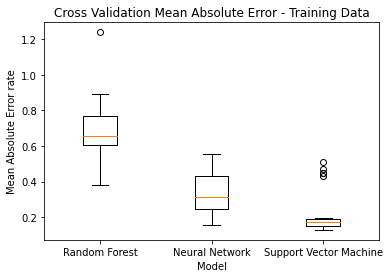

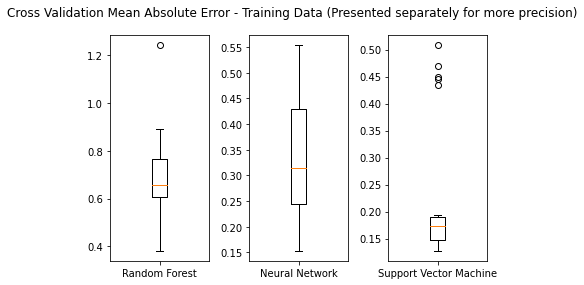

In [5]:
# Perform 5-fold cross validation. Done 5 times to reduce noise to get a result that is more comparable across runs.  random_state provided for reproducibility
cv = RepeatedKFold(n_repeats=5, random_state=1)
RF_scores = cross_val_score(RF_regressor, ff_train_inputs, ff_train_targets, scoring="neg_mean_absolute_error", cv=cv) * -1 # Uses the metrics.mean_absolute_error function to generate scores
NN_scores = cross_val_score(NN_regressor, ff_train_inputs, ff_train_targets, scoring="neg_mean_absolute_error", cv=cv) * -1  # The scores used by cross_val_score are negative so must be flipped to positive
SVM_scores = cross_val_score(SVM_regressor, ff_train_inputs, ff_train_targets, scoring="neg_mean_absolute_error", cv=cv) * -1

# Plot MAE from cross validation of each model as boxplots
plt.title("Cross Validation Mean Absolute Error - Training Data")
plt.boxplot([RF_scores, NN_scores, SVM_scores], labels=["Random Forest", "Neural Network", "Support Vector Machine"])
plt.xlabel("Model")
plt.ylabel("Mean Absolute Error rate")
plt.show()

# Also plot separately to show greater precision
fig, ax = plt.subplots(1,3)
ax[0].boxplot(RF_scores, labels=["Random Forest"])
ax[1].boxplot(NN_scores, labels=["Neural Network"])
ax[2].boxplot(SVM_scores, labels=["Support Vector Machine"])
fig.suptitle("Cross Validation Mean Absolute Error - Training Data (Presented separately for more precision)")
fig.tight_layout()
plt.show()

#### Final Assessment
All tuning has now been done, so a more reliable assessment of how well the model generalises can now be done using the **test** data

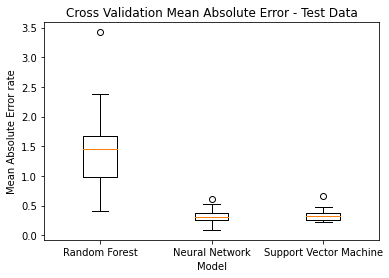

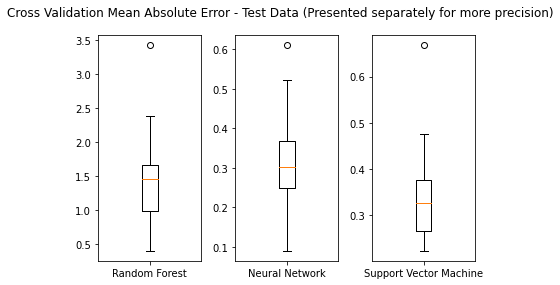

In [8]:
# Use 5-fold CV again
RF_scores_final = cross_val_score(RF_regressor, ff_test_inputs, ff_test_targets, scoring="neg_mean_absolute_error", cv=cv) * -1 
NN_scores_final = cross_val_score(NN_regressor, ff_test_inputs, ff_test_targets, scoring="neg_mean_absolute_error", cv=cv) * -1
SVM_scores_final = cross_val_score(SVM_regressor, ff_test_inputs, ff_test_targets, scoring="neg_mean_absolute_error", cv=cv) * -1

# Plot MAE from cross validation of each model as boxplots
plt.title("Cross Validation Mean Absolute Error - Test Data")
plt.boxplot([RF_scores_final, NN_scores_final, SVM_scores_final], labels=["Random Forest", "Neural Network", "Support Vector Machine"])
plt.xlabel("Model")
plt.ylabel("Mean Absolute Error rate")
plt.show()
# Plot separately
fig, ax = plt.subplots(1,3)
ax[0].boxplot(RF_scores_final, labels=["Random Forest"])
ax[1].boxplot(NN_scores_final, labels=["Neural Network"])
ax[2].boxplot(SVM_scores_final, labels=["Support Vector Machine"])
fig.suptitle("Cross Validation Mean Absolute Error - Test Data (Presented separately for more precision)")
fig.tight_layout()
plt.show()

The results for the Random Forest and SVM regressors on the test data are noticably worse than on the training data.  This is unsurprising for the SVM, as its hyperparameters were tuned using the cross validation results for the training data, so a certain degree of overfitting is not unexpected.  

For the Random Forest however, this is more surprising as it was left with the default parameters.  While it is possible that the default parameters just happen to overfit to the training set, this seems unlikely as the difference in performance is quite significant and the training and testing sets were shuffled before being separated (so the data in one set should not be too different from the other).  It therefore seems more likely that the issue is due to the test set being considerably smaller (25% of the overall set) than the training one, meaning that the regressor has less data to train on.  When doing cross validation on the training data, the model was trained on around 146 records each iteration; when using the testing data, this was reduced to around 48 records.

Unlike the other two, the Neural Network's performance was not much different, meaning that it generalises very well.

## Part 2- Evolutionary Computation

### Task 2.1 Generation of Random Solutions

In [48]:
import random
from statistics import mean

In [6]:
# Read in datasets
# Represent distances as adjacency matrix
distances_short = pandas.read_csv("datasets/distances_short.csv", header=None)
distances = pandas.read_csv("datasets/distances.csv", header=None)
# Map indices in the matrix to city names
with open("datasets/cities_short.txt", "r") as file:
    # Strip out newlines
    cities_short = [x.strip("\n") for x in file.readlines()]
with open("datasets/cities.txt", "r") as file:
    cities = [x.strip("\n") for x in file.readlines()]

In [7]:
def totalDistance(distances, route):
    # Takes adjacency matrix of distances, and a simple list of city indices for the route.  Returns total distance travelled along route
    total = 0
    if 0 < len(route):
        current_city = route[0]
        for i in range(1, len(route)):
            # First city in route does not contribute to distance, so start from second.
            total += distances[current_city][route[i]]
            current_city = route[i]
    return total

In [8]:
def generateRandom(cities):
    # Generate a random solution from the given set of cities
    # Needs to return indices, not city names so generate list of indices and shuffle it
    indices = [i for i in range(0, len(cities))]
    random.shuffle(indices)
    return indices

In [161]:
# Generate random solution
solution = generateRandom(cities_short)
solutionCities = []
for i in solution:
    solutionCities.append(cities_short[i])
print(f'Total distance for random solution {solution} ({solutionCities}) is {totalDistance(distances_short, solution)}')

Total distance for random solution [4, 0, 3, 1, 2] (['Edinburgh', 'Plymouth', 'Cardiff', 'Bristol', 'London']) is 1095


### Task 2.2 Algorithm Implementation

In [10]:
def swap(solution):
    # Randomly swap two cities in the given solution, and return as a new solution
    newSolution = solution.copy()
    if 1 < len(solution):
        # Decide which cities to swap
        firstPosition = random.randrange(len(solution))
        secondPosition = firstPosition
        while secondPosition == firstPosition:
            # Make sure the cities are different
            secondPosition = random.randrange(len(solution))
        # Swap them
        newSolution[firstPosition] = solution[secondPosition]
        newSolution[secondPosition] = solution[firstPosition]
        return newSolution  
    else:
        # Can't swap if there isn't at least two cities
        return solution

In [93]:
def hillClimber(distances, iterations, operator):
    # Takes in adjacency matrix of distances and the function to be used for mutation, and returns an optimised solution and list of best fitnesses for each iteration
    # Start with random solution
    solution = generateRandom(distances)
    best_fitness = totalDistance(distances, solution)
    fitness_archive = [best_fitness]
    # Repeatedly generate new solutions using operator.  If it is better than the existing solution add its fitness score to fitness_archive and keep it, otherwise discard it
    for i in range(iterations - 1):
        child_solution = operator(solution)
        child_fitness = totalDistance(distances, child_solution)
        if child_fitness < best_fitness:
            solution = child_solution
            best_fitness = child_fitness
        fitness_archive.append(best_fitness) 
    return solution, fitness_archive

### Task 2.3 Visualisation of Results

In [128]:
def plot(swap_fitnesses, ruin_and_recreate_fitnesses, dataset_name):
    # Plot results
    # Minimum
    plt.title(f"Minimum Fitnesses - {dataset_name}")
    plt.xlabel("Iterations")
    plt.ylabel("Distance")
    plt.plot(swap_fitnesses.min(axis=0))
    plt.plot(ruin_and_recreate_fitnesses.min(axis=0))
    plt.legend(["Swap", "Ruin and Recreate"], loc="upper right")
    plt.show()
    # Maximum
    plt.title(f"Maximum Fitnesses - {dataset_name}")
    plt.xlabel("Iterations")
    plt.ylabel("Distance")
    plt.plot(swap_fitnesses.max(axis=0))
    plt.plot(ruin_and_recreate_fitnesses.max(axis=0))
    plt.legend(["Swap", "Ruin and Recreate"], loc="upper right")
    plt.show()
    # Average
    plt.title(f"Average Fitnesses - {dataset_name}")
    plt.xlabel("Iterations")
    plt.ylabel("Distance")
    plt.plot(swap_fitnesses.mean(axis=0))
    plt.plot(ruin_and_recreate_fitnesses.mean(axis=0))
    plt.legend(["Swap", "Ruin and Recreate"], loc="upper right")
    plt.show()    

#### Shortened Dataset

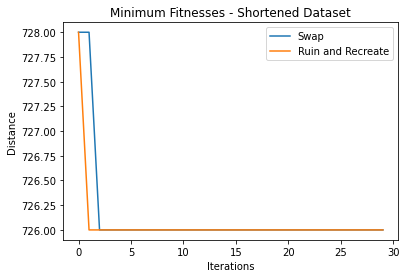

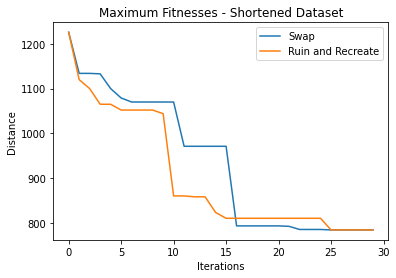

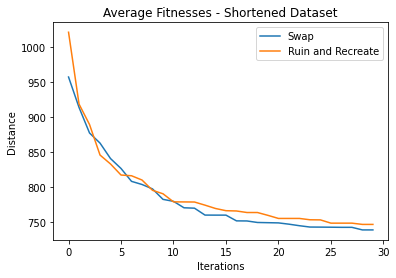

In [140]:
# Run with each mutator 30 times, and plot the minimum, maximum, and average fitnesses for each run
iterations_per_climb = 30
swap_fitnesses = np.empty((30, iterations_per_climb))
ruin_and_recreate_fitnesses = np.empty((30, iterations_per_climb))
for i in range(30):
    swap_fitnesses[i] = hillClimber(distances_short, iterations_per_climb, swap)[1]
    ruin_and_recreate_fitnesses[i] = hillClimber(distances_short, iterations_per_climb, generateRandom)[1]
plot(swap_fitnesses, ruin_and_recreate_fitnesses, "Shortened Dataset")

The minimum, maximum, and average are plotted on different graphs for readability

#### Full Dataset

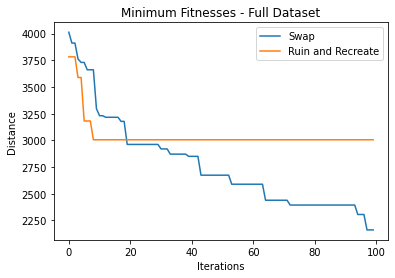

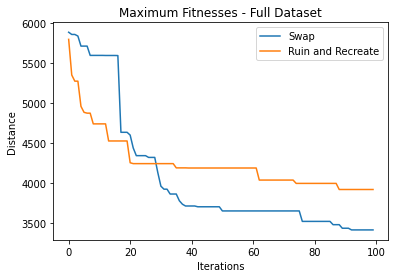

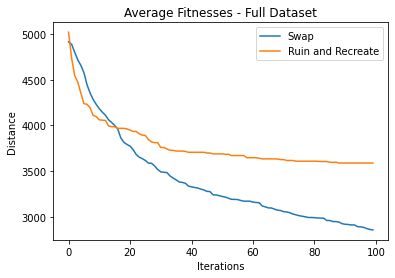

In [158]:
# Run with each mutator 30 times, and plot the minimum, maximum, and average fitnesses for each run
iterations_per_climb = 100
swap_fitnesses = np.empty((30, iterations_per_climb))
ruin_and_recreate_fitnesses = np.empty((30, iterations_per_climb))
for i in range(30):
    swap_fitnesses[i] = hillClimber(distances, iterations_per_climb, swap)[1]
    ruin_and_recreate_fitnesses[i] = hillClimber(distances, iterations_per_climb, generateRandom)[1]
plot(swap_fitnesses, ruin_and_recreate_fitnesses, "Full Dataset")

The value of 100 for `iterations_per_climb` was arrived at after experimenting with different values.   As `iterations_per_climb` increased beyond 100, swap only continued to improve while ruin-and-recreate did not.  100 was therefore considered sufficient as it shows how the trend for ruin-and-recreate has levelled out while swap has not, without taking too long for the program to run.

#### Conclusion

The results show that the swap operator is better for this problem.  Although ruin-and-recreate initially seems to decrease more quickly, its improvement eventually starts to plateau.  This is likely due to reaching a local optimum; where it is unable to improve without first getting worse.

The swap operator, on the other hand, does not appear to suffer from this problem (or at least not for many more iterations than were attempted) allowing it to continue improving long after ruin-and-recreate has stopped.

Ruin-and-recreate is likely more vulnerable to reaching a local optimum than swap because it is more destructive: it destroys the existing solution and completely regenerates it at random.  The better a solution is, the smaller the probability of a random solution being better; therefore once it reaches a relatively optimal solution the chance of a random route being better becomes too small for improvement to be likely in the available number of iterations.

Swap likely does not suffer from this problem as much as it only makes small changes to the parent solution, this means that cities that are in a relatively optimal position are kept there while those that are not can be swapped.  This allows it to improve the same solution over time.

Given enough iterations, ruin-and-recreate would likely continue to improve; and eventually swap may also hit a local optimum and fail to improve further.  However, for the number of iterations used swap is the better operator for this problem.


# References
Jermain, N., 2019. Optimizing Hyperparameters for Random Forest Algorithms in scikit-learn. [Blog] Open Data Science, Available at: https://opendatascience.com/optimizing-hyperparameters-for-random-forest-algorithms-in-scikit-learn/ [Accessed 22 April 2021].

Boehmke, B. and Greenwell, B., 2020. Hands-On Machine Learning with R. [ebook] Chapter 11. Available at: https://bradleyboehmke.github.io/HOML/ [Accessed 25 April 2021].